In [7]:
import pandas as pd
import numpy as np
import glob

In [8]:
# data 폴더의 모든 csv 합치기
files = glob.glob("./data/*.csv")

dfs = [pd.read_csv(f) for f in files]
df_all = pd.concat(dfs, ignore_index=True)

df_all.to_csv("./data/merged.csv", index=False)

In [ ]:
THRESHOLD = 0.5      # 50% 성장 임계값
WINDOW_MIN = 10      # 10분 버킷
CSV_PATH = "./data/merged.csv"  # ← 네 CSV 경로

# 1) CSV 읽기 & 시간 파싱
df = pd.read_csv(CSV_PATH)
df["uploaded_time"] = pd.to_datetime(df["uploaded_time"], utc=True)

# 2) 10분 버킷 생성
df["bucket_ts"] = df["uploaded_time"].dt.floor(f"{WINDOW_MIN}min")

# 3) 10분 단위 카운트 (채널별)
cnt = (
    df.groupby(["channel", "bucket_ts"], as_index=False)
      .size()
      .rename(columns={"size": "cnt"})
      .sort_values(["channel", "bucket_ts"])
      .reset_index(drop=True)
)

# 4) 증가율 (이전 버킷 대비)
cnt["prev_cnt"] = cnt.groupby("channel")["cnt"].shift(1)
cnt["growth"] = np.where(
    (cnt["prev_cnt"].isna()) | (cnt["prev_cnt"] <= 0),
    0.0,
    (cnt["cnt"] - cnt["prev_cnt"]) / cnt["prev_cnt"] * 100
)

# 이동평균 (window=3: 앞뒤 3구간 평균)
cnt["count_ma"] = cnt["cnt"].rolling(window=3, center=True).mean()
# 이동평균 기준 증가율
cnt["growth_rate_ma"] = cnt["count_ma"].pct_change() * 100

cnt.head()


/var/folders/bt/4vlvrjs94q5cr_8p6dqhnwvc0000gn/T/ipykernel_64865/1163043562.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  cnt["growth_rate_ma"] = cnt["count_ma"].pct_change() * 100


,channel,bucket_ts,cnt,prev_cnt,growth,count_ma,growth_rate_ma
0,X,2025-08-01 00:00:00+00:00,1,NaN,0.000000,NaN,NaN
1,X,2025-08-01 00:20:00+00:00,3,1.0,200.000000,3.000000,NaN
2,X,2025-08-01 00:30:00+00:00,5,3.0,66.666667,3.000000,0.000000
3,X,2025-08-01 00:50:00+00:00,1,5.0,-80.000000,3.333333,11.111111
4,X,2025-08-01 01:00:00+00:00,4,1.0,300.000000,2.333333,-30.000000


In [17]:
# 5) 임계 초과 & 연속 3회(streak) 계산
cnt["exceed"] = (cnt["growth"] >= THRESHOLD).astype(int)

# ===== 방법 A: transform 버전 (권장) =====
grp = cnt.groupby("channel")["exceed"].transform(lambda s: s.eq(0).cumsum())
streak = cnt.groupby([cnt["channel"], grp]).cumcount() + 1
cnt["streak"] = np.where(cnt["exceed"].astype(bool), streak, 0).astype(int)

alerts = cnt.query("streak >= 3").copy()

alerts.head()

,channel,bucket_ts,cnt,prev_cnt,growth,count_ma,growth_rate_ma,exceed,streak
2,X,2025-08-01 00:30:00+00:00,5,3.0,0.666667,3.000000,0.000000,1,3
22,X,2025-08-01 05:10:00+00:00,3,2.0,0.500000,2.333333,16.666667,1,3
45,X,2025-08-01 09:40:00+00:00,3,2.0,0.500000,2.000000,0.000000,1,3
108,X,2025-08-01 23:30:00+00:00,23,12.0,0.916667,14.666667,2.325581,1,3
239,X,2025-08-02 21:30:00+00:00,6,3.0,1.000000,4.333333,18.181818,1,3


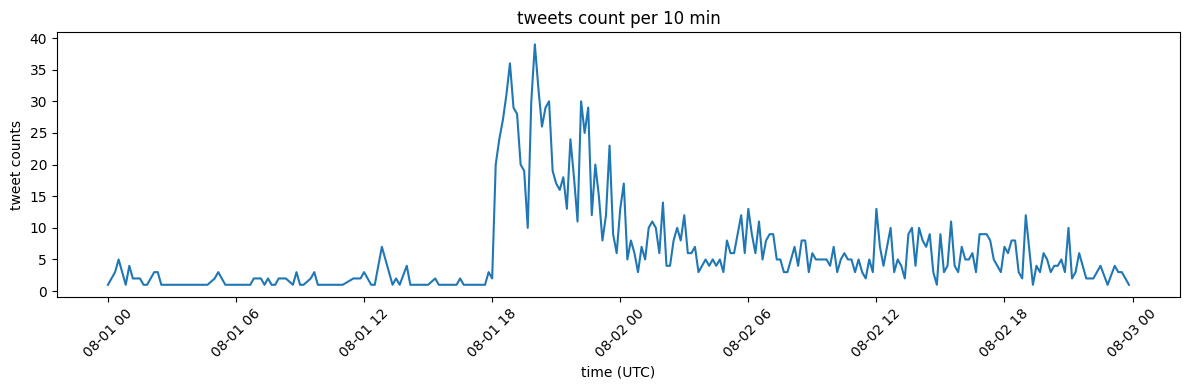

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(cnt["bucket_ts"], cnt["cnt"])
plt.title("tweets count per 10 min")
plt.xlabel("time (UTC)")
plt.ylabel("tweet counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


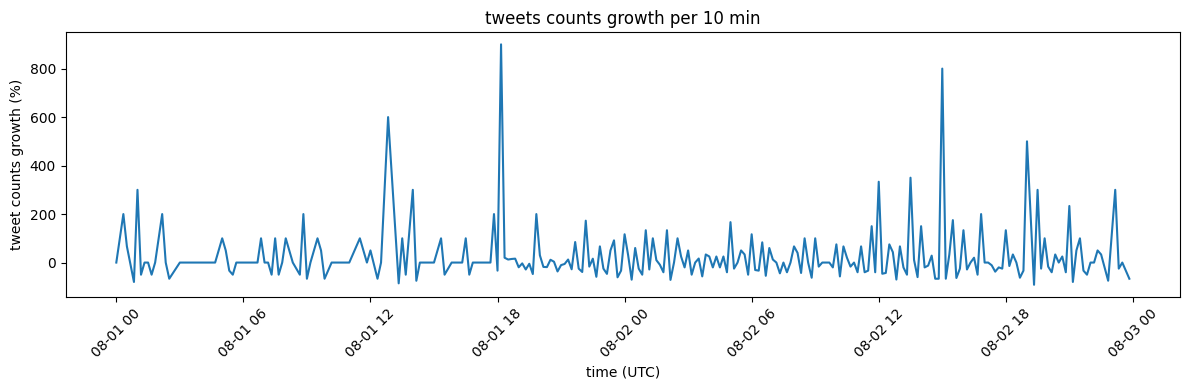

In [21]:
plt.figure(figsize=(12,4))
plt.plot(cnt["bucket_ts"], cnt["growth"])
plt.title("tweets counts growth per 10 min")
plt.xlabel("time (UTC)")
plt.ylabel("tweet counts growth (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


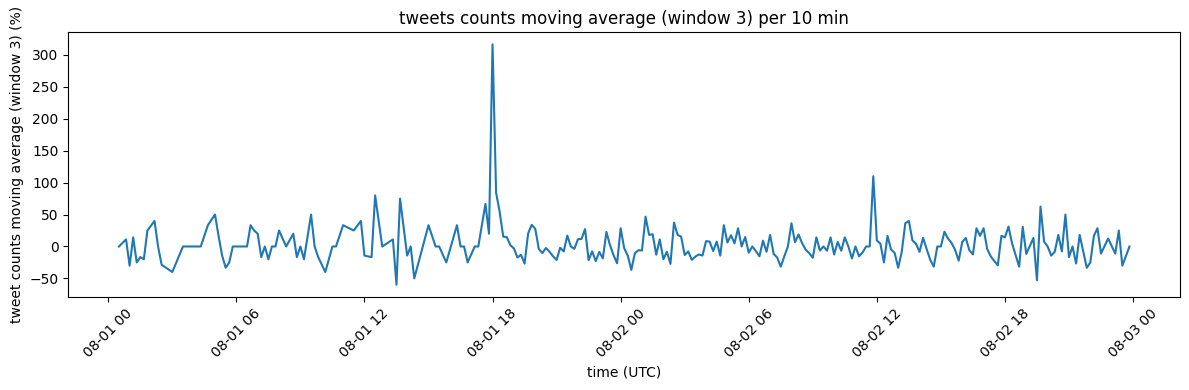

In [22]:
plt.figure(figsize=(12,4))
plt.plot(cnt["bucket_ts"], cnt["growth_rate_ma"])
plt.title("tweets counts moving average (window 3) per 10 min")
plt.xlabel("time (UTC)")
plt.ylabel("tweet counts moving average (window 3) (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
